In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
## language processing libraries

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import unicodedata,re,string
from string import punctuation

In [168]:
data = pd.read_csv("data/full-corpus.csv")

In [169]:
data.head()

,Topic,Sentiment,TweetId,TweetDate,TweetText
0,apple,positive,126415614616154112,Tue Oct 18 21:53:25 +0000 2011,Now all @Apple has to do is get swype on the i...
1,apple,positive,126404574230740992,Tue Oct 18 21:09:33 +0000 2011,@Apple will be adding more carrier support to ...
2,apple,positive,126402758403305474,Tue Oct 18 21:02:20 +0000 2011,Hilarious @youtube video - guy does a duet wit...
3,apple,positive,126397179614068736,Tue Oct 18 20:40:10 +0000 2011,@RIM you made it too easy for me to switch to ...
4,apple,positive,126395626979196928,Tue Oct 18 20:34:00 +0000 2011,I just realized that the reason I got into twi...


In [170]:
data["Sentiment"].unique()

array(['positive', 'negative', 'neutral', 'irrelevant'], dtype=object)

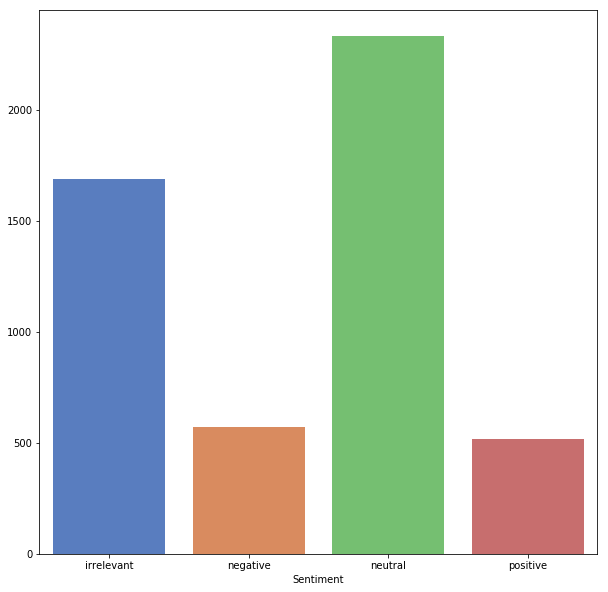

In [171]:
x = data.groupby(["Sentiment"]).size()
plt.figure(figsize=(10,10))
sns.barplot(x.keys(),x.values,palette="muted")

In [172]:
from sklearn.preprocessing import LabelEncoder

In [173]:
label_encoder = LabelEncoder()

In [174]:
data["Sentiment"] = label_encoder.fit_transform(data["Sentiment"])

In [175]:
data["Sentiment"].unique()

array([3, 1, 2, 0], dtype=int64)

In [176]:
import twitter
import time
import os
import csv

cons_key = "__"
cons_sec = "__"
acc_key = "____"
acc_sec = "__"

# initialize api instance
twitter_api = twitter.Api(consumer_key=cons_key,
                        consumer_secret=cons_sec,
                        access_token_key=acc_key,
                        access_token_secret=acc_sec)

# test authentication
print(twitter_api.VerifyCredentials())

{"created_at": "Sat Oct 05 17:34:40 +0000 2019", "default_profile": true, "description": "Dev Account XD", "id": 1180536763346894849, "id_str": "1180536763346894849", "name": "99PercentBeast", "profile_background_color": "F5F8FA", "profile_image_url": "http://pbs.twimg.com/profile_images/1180536857290932224/SmY5M2ff_normal.jpg", "profile_image_url_https": "https://pbs.twimg.com/profile_images/1180536857290932224/SmY5M2ff_normal.jpg", "profile_link_color": "1DA1F2", "profile_sidebar_border_color": "C0DEED", "profile_sidebar_fill_color": "DDEEF6", "profile_text_color": "333333", "profile_use_background_image": true, "screen_name": "beast_percent", "status": {"created_at": "Sun Oct 06 06:28:26 +0000 2019", "id": 1180731521549758465, "id_str": "1180731521549758465", "lang": "en", "source": "<a href=\"https://epic-sentiment-analysis.com\" rel=\"nofollow\">epic-sentiment-analysis</a>", "text": "This is post update on twitter"}, "statuses_count": 1}


In [177]:
def buildTestSet(search_keyword):
    try:
        tweets_fetched = twitter_api.GetSearch(search_keyword, count = 100)
        
        print("Fetched " + str(len(tweets_fetched)) + " tweets for the term " + search_keyword)
        
        return [{"text":status.text, "label":None} for status in tweets_fetched]
    except:
        print("Unfortunately, something went wrong..")
        return None

In [178]:
search_term = input("Enter a search keyword:")
testDataSet = buildTestSet(search_term)

print(testDataSet[0:4])

Enter a search keyword: india


Fetched 100 tweets for the term india
[{'text': 'Churches in India are very pro-environment\n\nThey protested against:\n1. Metro shed in Aarey\n2. Bangalore Metro const… https://t.co/fIf9P3CnDM', 'label': None}, {'text': '• Thousands of forces deployed\n• Security crackdown imposed\n• Communications blackout\n• Severe restrictions of move… https://t.co/2FQZhA4Url', 'label': None}, {'text': 'Mumbai pays 30% of India’s total corporate &amp; personal tax (in effect subsiding other cities’ infra), hosts 80% of I… https://t.co/EI911w5rjp', 'label': None}, {'text': 'RT @ByRakeshSimha: Hearing of Aarey, my Chinese friend said: "India has the potential to be a bigger economy than us, but you won\'t because…', 'label': None}]


In [179]:
testdata = pd.DataFrame.from_dict(testDataSet)

In [180]:
testdata.head()

,label,text
0,None,Churches in India are very pro-environment\n\n...
1,None,• Thousands of forces deployed\n• Security cra...
2,None,Mumbai pays 30% of India’s total corporate &am...
3,None,"RT @ByRakeshSimha: Hearing of Aarey, my Chines..."
4,None,RT @rao_jaiveer: Isha Volunteers from the US h...


<h2> TF-IDF </h2>
<p>
<h3> Term Frequency (TF) </h3> </br>
<h5> 
    Scoring of the frequency of the word in the current document </br>
    Since every document is different in length, it is possible that a term would appear much more times in long documents than
    shorter ones.</br>
    The term frequency is often divided by the document length to normalize.</br>   
</h5>
<h4> Formula : </br>TF(t) = No. of times term t appear in document /  Total No. of term in document
</h4>
</p>

<p>
<h3> Inverse Document Frequency (IDF)</h3> </br>
<h5> 
    Scoring of how rare the word is across documents </br>
    IDF is a measure of how rare a term is. Rarer the term, more is the IDF score.</br>  
</h5>
<h4> Formula : </br>IDF(t) = log_e (Total no. of document / Total no. of document with term t in it)
</h4>
</p>

In [191]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold

In [192]:
svc = LinearSVC(
    C=1.0,
    class_weight='balanced',
    dual=True,
    fit_intercept=True,
    intercept_scaling=1,
    loss='squared_hinge',
    max_iter=1000,
    multi_class='ovr',
    penalty='l2',
    random_state=0,
    tol=1e-05, 
    verbose=0
)

tfidf = CountVectorizer(
    input='content',
    encoding='utf-8',
    decode_error='strict',
    strip_accents=None,
    lowercase=True,
    preprocessor=None,
    tokenizer=None,
    stop_words=None,
    token_pattern=r"(?u)\b\w\w+\b",
    ngram_range=(1, 1),
    analyzer='word',
    max_df=1.0,
    min_df=1,
    max_features=None,
    vocabulary=None,
    binary=False,
    dtype=np.int64
)

pipeline = Pipeline([
    ('tfidf', tfidf),
    ('svc', svc),
])

In [193]:
skf = StratifiedKFold(n_splits=3)

X = data["TweetText"]
y = data["Sentiment"]

for train, test in skf.split(X, y):
    pipeline.fit(X[train], y[train])
    train_score = pipeline.score(X[train], y[train])
    test_score = pipeline.score(X[test], y[test])
    print("Train = {}, Test = {}".format(train_score, test_score))

Train = 0.9985328638497653, Test = 0.4574780058651026
Train = 0.9982394366197183, Test = 0.5929618768328446
Train = 0.9991202346041056, Test = 0.6283029947152085
